### Fitting for one sample

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from cmdstanpy import cmdstan_path, CmdStanModel

In [3]:
indata = pd.read_csv('intensity_table.csv')

In [4]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R
mydf['sig_IR'] = mydf['sigma_I']/mydf.R

mydf = mydf.sort_values('phases').reset_index(drop=True)

<AxesSubplot:xlabel='two_th', ylabel='IR'>

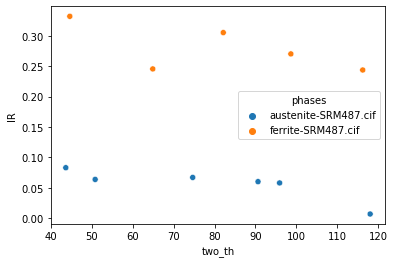

In [5]:
sns.scatterplot(data=mydf,x='two_th',y='IR',hue='phases')

In [6]:
mydf.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR
0,21716.194,261157.488,168.301,austenite-SRM487.cif,43.593,0.083154,0.000644
1,7812.145,122379.402,123.253,austenite-SRM487.cif,50.777,0.063835,0.001007
2,4734.357,70554.804,103.257,austenite-SRM487.cif,74.651,0.067102,0.001464
3,4864.974,80763.209,110.421,austenite-SRM487.cif,90.633,0.060238,0.001367
4,1368.346,23555.357,80.239,austenite-SRM487.cif,95.910,0.058091,0.003406


In [7]:
mydf['phase_id'] = 0

In [8]:
unique_phases = np.unique(mydf.phases)

In [9]:
for ii, pn in enumerate(unique_phases):
    mydf.loc[mydf['phases'] == pn,'phase_id'] = ii+1

In [10]:
mydf.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR,phase_id
0,21716.194,261157.488,168.301,austenite-SRM487.cif,43.593,0.083154,0.000644,1
1,7812.145,122379.402,123.253,austenite-SRM487.cif,50.777,0.063835,0.001007,1
2,4734.357,70554.804,103.257,austenite-SRM487.cif,74.651,0.067102,0.001464,1
3,4864.974,80763.209,110.421,austenite-SRM487.cif,90.633,0.060238,0.001367,1
4,1368.346,23555.357,80.239,austenite-SRM487.cif,95.910,0.058091,0.003406,1


### Stan starts here

In [50]:
stan_file = 'one_sample.stan'

In [36]:
model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan file C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\one_sample.stan to exe file C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\one_sample.exe
INFO:cmdstanpy:compiled model executable: C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\one_sample.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/dtn1/Documents/AusteniteCalc/austenitecalculator/ExampleScripts/one_sample.hpp C:/Users/dtn1/Documents/AusteniteCalc/austenitecalculator/ExampleScripts/one_sample.stan
Warning in 'C:/Users/dtn1/Documents/AusteniteCalc/austenitecalculator/ExampleScripts/one_sample.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g+

In [51]:
os.listdir()

['.ipynb_checkpoints',
 'cif_composition_simulations.ipynb',
 'compute_structure_factor.ipynb',
 'GSASIIscript-LeBailSingleLikeGSAS.ipynb',
 'hello_world.exe',
 'hello_world.hpp',
 'hello_world.stan',
 'intensity_table.csv',
 'InteractionVolume-Plot.ipynb',
 'InteractionVolume.ipynb',
 'one_sample.exe',
 'one_sample.hpp',
 'one_sample.stan',
 'pf_uncertainty_conjugate_priors.ipynb',
 'pf_uncertainty_stan.ipynb',
 'pf_uncertainty_with_pymc3.ipynb',
 'pf_uq_math.ipynb',
 'ScatteringFactor.ipynb',
 'XRDSystem-parameters.xlsx']

In [52]:
stan_data = {
    "N":mydf.shape[0],
    "N_phases":len(np.unique(mydf.phases)),
    "Y":mydf.IR,
    "phase":mydf.phase_id,
    "prior_scale":np.std(mydf.IR),
    "prior_location":np.mean(mydf.IR)
}

stan_init = {
    "mu_phase":np.mean(mydf.IR),
    "sigma_exp":np.std(mydf.IR)
}

In [58]:
start = time.time()
fit = model.sample(data=stan_data,
                   #inits=stan_init,
                   chains=4,
                   iter_warmup=1000, 
                   iter_sampling=1000)
end = time.time()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [59]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,20.000,0.05600,1.800,17.000,20.000,22.000,1000.0,3400.0,1.0
sigma_exp[1],0.035,0.00044,0.017,0.019,0.031,0.063,1435.0,4673.0,1.0
sigma_exp[2],0.055,0.00074,0.026,0.027,0.049,0.110,1296.0,4220.0,1.0
phase_mu[1],0.057,0.00038,0.016,0.034,0.057,0.082,1675.0,5457.0,1.0
phase_mu[2],0.280,0.00097,0.028,0.230,0.280,0.320,857.0,2793.0,1.0


### Multiple samples

In [12]:
multiple_df = pd.concat((mydf.copy(),mydf.copy(),mydf.copy())).reset_index(drop=True)
multiple_df['sample_id'] = np.repeat((0,1,2),11)
np.random.seed(123)

for ii in range(3):
    multiple_df.loc[multiple_df['sample_id']==ii,'I'] = multiple_df['I'].loc[multiple_df['sample_id']==ii]*(1+ii/2)
    
multiple_df['I'] = multiple_df['I'] + np.random.normal(0,multiple_df['I']/10,multiple_df.shape[0])
multiple_df['IR'] = multiple_df['I']/multiple_df['R']

In [39]:
multiple_df['sample_id'] = multiple_df['sample_id'] + 1

In [40]:
multiple_df.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR,phase_id,sample_id
0,19358.617521,261157.488,168.301,austenite-SRM487.cif,43.593,0.074126,0.000644,1,1
1,8591.285724,122379.402,123.253,austenite-SRM487.cif,50.777,0.070202,0.001007,1,1
2,4868.329123,70554.804,103.257,austenite-SRM487.cif,74.651,0.069001,0.001464,1,1
3,4132.165538,80763.209,110.421,austenite-SRM487.cif,90.633,0.051164,0.001367,1,1
4,1289.173466,23555.357,80.239,austenite-SRM487.cif,95.910,0.054730,0.003406,1,1


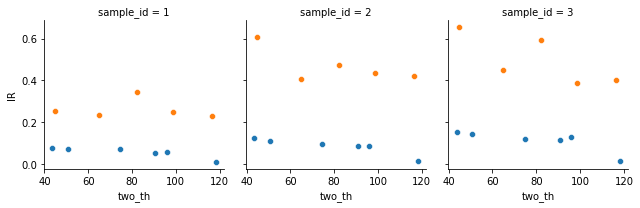

In [41]:
#multiple_df
g = sns.FacetGrid(multiple_df,col='sample_id',hue='phases')
g.map(sns.scatterplot,'two_th','IR')

### Stan starts here

In [42]:
stan_file = 'multiple_samples.stan'

In [43]:
model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan file C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\multiple_samples.stan to exe file C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\multiple_samples.exe
INFO:cmdstanpy:compiled model executable: C:\Users\dtn1\Documents\AusteniteCalc\austenitecalculator\ExampleScripts\multiple_samples.exe


In [44]:
stan_data = {
    "N":multiple_df.shape[0],
    "N_samples":len(np.unique(multiple_df.sample_id)),
    "N_phases":len(np.unique(multiple_df.phases)),
    "Y":multiple_df.IR,
    "phase":multiple_df.phase_id,
    "group":multiple_df.sample_id,
    "prior_scale":np.std(multiple_df.IR),
    "prior_location":np.mean(multiple_df.IR)
}

stan_init = {
    "mu_phase":np.mean(multiple_df.IR),
    "sigma_exp":np.std(multiple_df.IR),
    "sigma_sample":np.std(multiple_df.IR),
    "group_effect":0
}

In [45]:
start = time.time()
fit = model.sample(data=stan_data,
                   #inits=stan_init,
                   chains=4,
                   iter_warmup=1000, 
                   iter_sampling=1000)
end = time.time()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [46]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,68.0000,0.06600,2.2000,64.000,69.0000,71.000,1100.0,1200.0,1.0
sigma_sample,0.0670,0.00150,0.0510,0.016,0.0530,0.170,1200.0,1300.0,1.0
sigma_exp[1],0.0430,0.00023,0.0088,0.031,0.0420,0.059,1458.0,1572.0,1.0
sigma_exp[2],0.1300,0.00058,0.0260,0.090,0.1200,0.170,2043.0,2202.0,1.0
phase_mu[1],0.0870,0.00160,0.0380,0.028,0.0850,0.160,566.0,610.0,1.0
phase_mu[2],0.4100,0.00180,0.0480,0.340,0.4100,0.500,722.0,778.0,1.0
group_effect[1],-0.0390,0.00160,0.0400,-0.120,-0.0330,0.018,595.0,641.0,1.0
group_effect[2],0.0027,0.00150,0.0380,-0.064,0.0046,0.063,610.0,657.0,1.0
group_effect[3],0.0250,0.00160,0.0390,-0.044,0.0240,0.089,627.0,675.0,1.0


In [47]:
end - start

1.2190110683441162